In [16]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model
from skimage import io
import pyvista as pv
from trimesh import smoothing, Trimesh, proximity
from trimesh.curvature import discrete_mean_curvature_measure,sphere_ball_intersection

import ipyvolume as ipv

%load_ext autoreload
%autoreload 2

In [2]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['Region','Meta'] = name
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [3]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

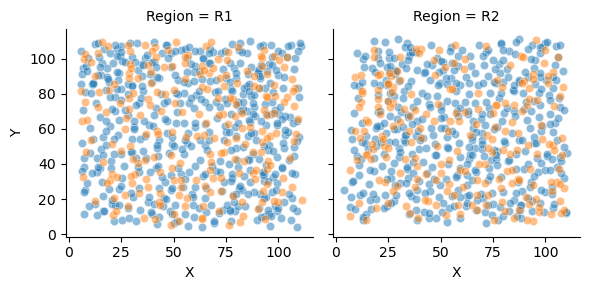

In [4]:
g = sb.FacetGrid(births.droplevel(1,axis=1), col='Region',hue='Will differentiate')
g.map(sb.scatterplot,'X','Y',alpha=0.5)
# plt.legend()

## Spatially plot curvature and point processes

<Axes: xlabel='X', ylabel='Y'>

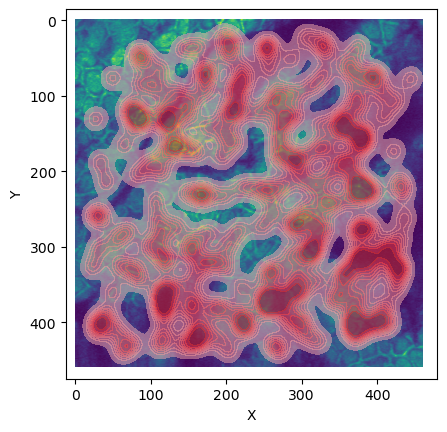

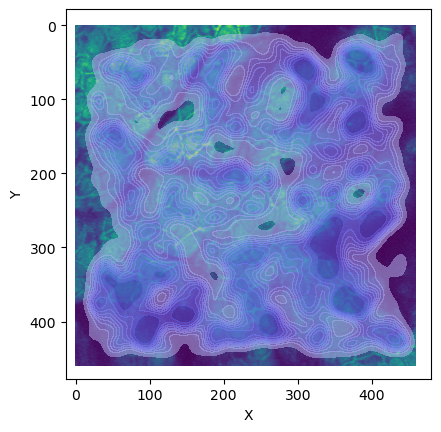

In [5]:
dx = .25
t0 = io.imread(path.join(path.join(dirnames['R1'],'im_seq/t0.tif')))

_diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
_diff = _diff[_diff['Region'] == 'R1']
_diff['X'] /= dx; _diff['Y'] /= dx
# plt.scatter(_df['X']/dx,_df['Y']/dx,color='r',alpha=0.5)
ax = plt.imshow(t0[55,...,1])
sb.kdeplot(_diff,x='X',y='Y',color='r',bw_method=0.1, fill=True, alpha=0.5)

plt.figure()
_div = births[~births['Will differentiate','Meta']].droplevel(level=1,axis=1)
_div = _div[_div['Region'] == 'R1']
_div['X'] /= dx; _div['Y'] /= dx
ax = plt.imshow(t0[55,...,1])
sb.kdeplot(_div,x='X',y='Y',color='b',bw_method=0.1, fill=True, alpha=0.5)
# sb.kdeplot(_diff,x='X',y='Y',color='b',bw_method=0.1, fill=False, alpha=0.5)

In [37]:
# Plotting utils

from measurements import get_mesh_from_bm_image, get_tissue_curvatures

def plot_mesh_curvature_kde_overlay(mesh,curv,df,colormap='viridis',color='r',title=None,dx=0.25,dz=1,alpha=0.3):
    X_ = mesh.vertices[:,0]; Y_ = mesh.vertices[:,1]
    
    plt.scatter(X_/dx,Y_/dx,c=curv,cmap = colormap, alpha=0.5)
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == 'R1']
    _diff['X'] /= dx; _diff['Y'] /= dx
    sb.kdeplot(df,x='X',y='Y',color='r',bw_method=0.1, fill=True, alpha=alpha)
    plt.title(title)

def plot_mesh_curvature_scatter_overlay(mesh,curv,df,color='r',title=None,dx=0.25,dz=1, alpha=0.3):
    X_ = mesh.vertices[:,0]; Y_ = mesh.vertices[:,1]
    
    plt.scatter(X_/dx,Y_/dx,c=curv,cmap = 'BrBG')
    plt.colorbar()
    plt.clim([-1.5,1.5])
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == 'R1']
    _diff['X'] /= dx; _diff['Y'] /= dx
    plt.scatter(df['X'],df['Y'],color='r',alpha=.6)
    plt.title(title)
    

0
1


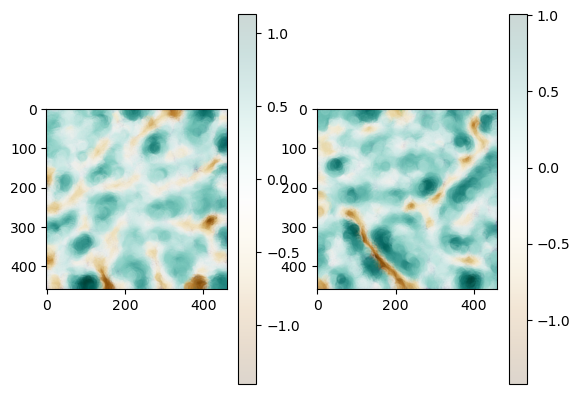

In [35]:
regions = ['R1','R2']

kappa=7
dx=0.25;dz=1
t= 0

for i,region in enumerate(regions):
    print(i)
    plt.subplot(1,2,i+1)
    bm_img = io.imread(path.join(dirnames[region],f'Image flattening/height_image/t{t}.tif'))
    mesh = get_mesh_from_bm_image(bm_img)
    mean_curve,_ = get_tissue_curvatures(mesh,kappa=kappa)
    _div = births[~births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _div = _div[_div['Region'] == region]
    _div['X'] /= dx; _div['Y'] /= dx
    _diff = births[births['Will differentiate','Meta']].droplevel(level=1,axis=1)
    _diff = _diff[_diff['Region'] == region]
    _diff['X'] /= dx; _diff['Y'] /= dx
    
    ax = plt.imshow(t0[55,...,1])
    ax = plt.scatter(mesh.vertices[:,0]/.25,mesh.vertices[:,1]/.25,c=mean_curve,cmap='BrBG',alpha=0.2)
    plt.colorbar()
    

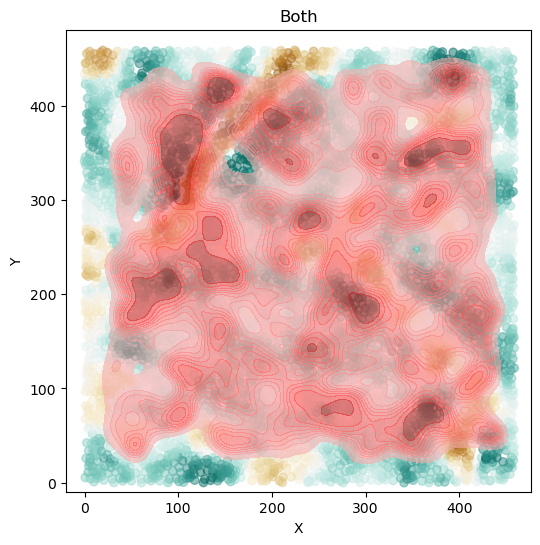

In [38]:
fig=plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

# plot_mesh_curvature_kde_overlay(mesh, mean_curve, _div,color='r',title='Diff',colormap='BrBG',alpha=.6)
# plot_mesh_curvature_kde_overlay(mesh, mean_curve, _div,color='r',title='Div',colormap='BrBG',alpha=.6)
plot_mesh_curvature_kde_overlay(mesh, mean_curve, pd.concat((_div,_diff)),color='r',title='Both',colormap='BrBG',alpha=.6)


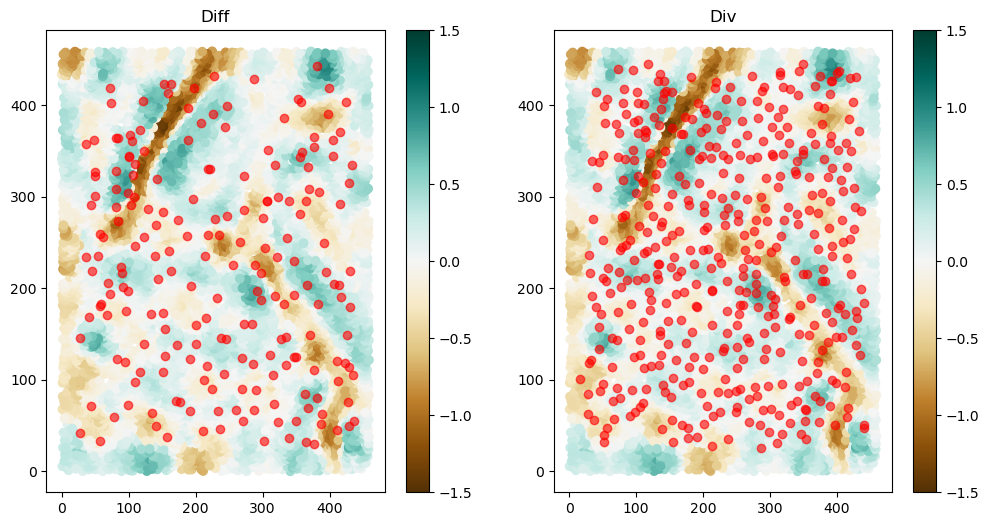

In [23]:

fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plot_mesh_curvature_scatter_overlay(mesh, mean_curve, _diff ,color='r',title='Diff', alpha=0.2)
plt.subplot(1,2,2)
plot_mesh_curvature_scatter_overlay(mesh,mean_curve, _div,color='r',title='Div')


In [25]:
# Recalculate mean curvature w different kappas

result = []
for kappa in tqdm(range(2,20)):
    for region,dirname in dirnames.items():
        for t in range(13):
            _df = pd.DataFrame()
            this_region_frame = divisions.loc[t,:].droplevel(axis=1,level=1)
            this_region_frame = this_region_frame[this_region_frame['Region'] == region]
            this_region_frame = this_region_frame[~this_region_frame['Border'].astype(bool)]
            this_region_frame = this_region_frame.dropna(subset=['X','Y','Z','At least one daughter differentiated'])
            if len(this_region_frame) < 1:
                continue
            coords_3d_um = this_region_frame[['X','Y','Z']].values

            mesh = get_mesh(dirname,t=t)
            query_points = mesh.nearest.on_surface(coords_3d_um)[0]
            mean_curv = get_tissue_curvature(mesh,kappa,query_pts=query_points)

            _df['>1 diff daughter'] = this_region_frame['At least one daughter differentiated']
            _df['# daughter diff'] = this_region_frame['Num daughter differentiated']
            _df['Mean curvature'] = mean_curv
            _df['Kappa'] = kappa
            _df['Region'] = region
            _df['Frame'] = t
            _df['Dividing'] = True

            _df_rand = pd.DataFrame()
            random_non_dividing_cell = all_df.loc[t,:].droplevel(axis=1,level=1)
            random_non_dividing_cell = random_non_dividing_cell[~random_non_dividing_cell['Divide next frame']]
            random_non_dividing_cell = random_non_dividing_cell.dropna(subset=['X','Y','Z'])
            random_non_dividing_cell = random_non_dividing_cell.sample(len(query_points))
            coords_3d_um = random_non_dividing_cell[['X','Y','Z']].values

            query_points = mesh.nearest.on_surface(coords_3d_um)[0]
            mean_curv = get_tissue_curvature(mesh,kappa,query_pts=query_points)

            _df_rand['Mean curvature'] = mean_curv
            _df_rand['Kappa'] = kappa
            _df_rand['Region'] = region
            _df_rand['Frame'] = t
            _df_rand['>1 diff daughter'] = 0
            _df_rand['# daughter diff'] = 0
            _df_rand['Dividing'] = False
            
            result.append(_df)
            result.append(_df_rand)              

result = pd.concat(result,ignore_index=True)

100%|███████████████████████████████████████████| 18/18 [01:16<00:00,  4.25s/it]


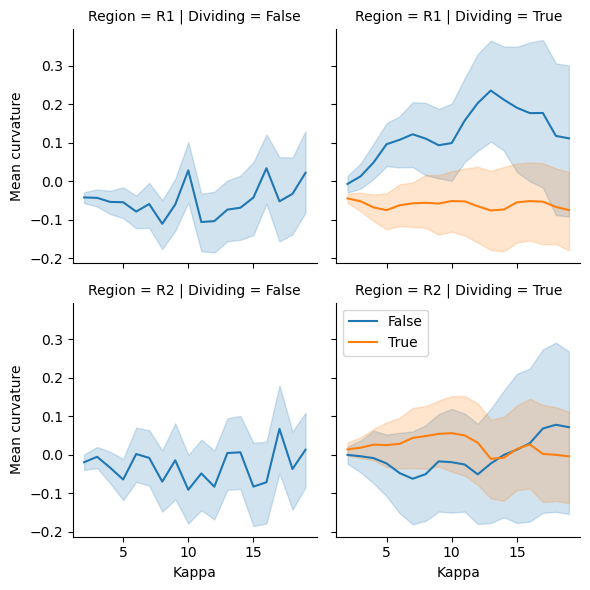

In [26]:
result['Abs curvature'] = result['Mean curvature'].abs()

g = sb.FacetGrid(data=result,col='Dividing',row='Region')
g.map_dataframe(sb.lineplot,x='Kappa',y='Mean curvature',hue='>1 diff daughter',
               errorbar=('ci'))
plt.legend()

# result[result.Dividing]

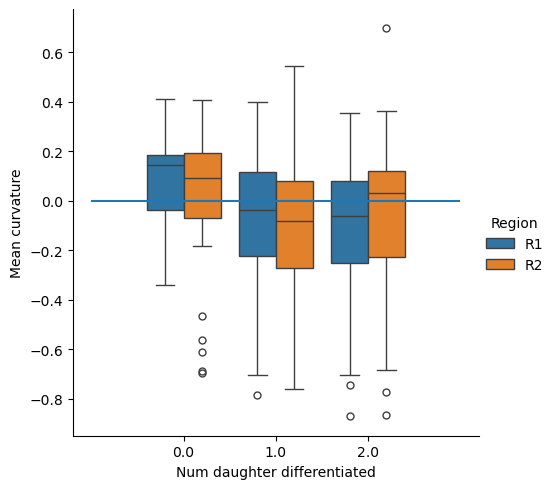

In [39]:

sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature',kind='box',hue='Region')
plt.hlines(y=0,xmin=-1,xmax=3)


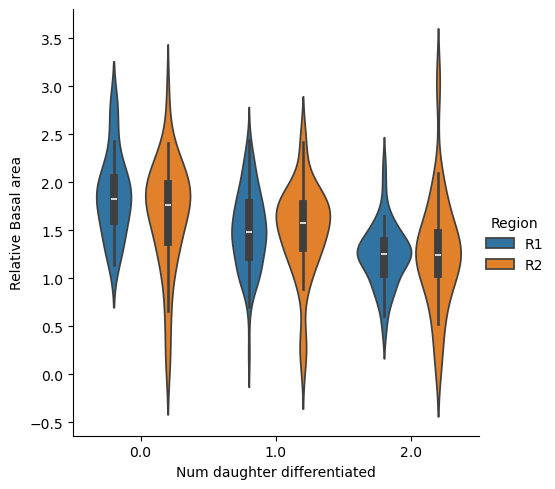

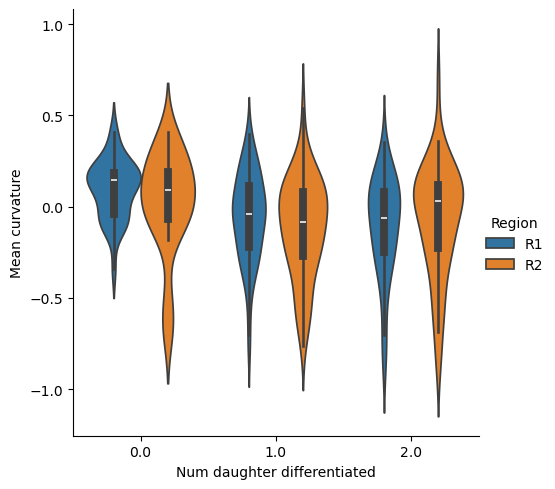

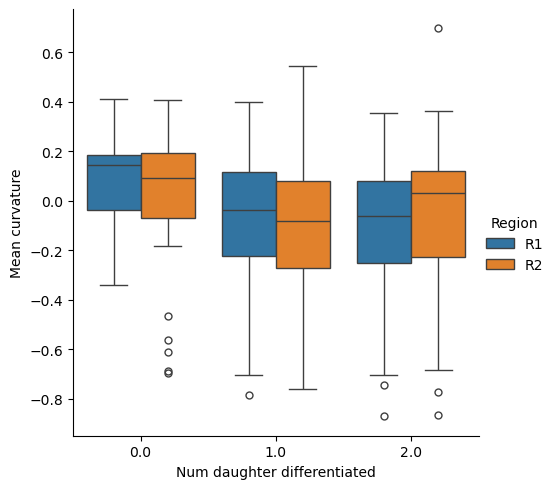

In [87]:

sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Relative Basal area',hue='Region',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature',hue='Region',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Mean curvature',hue='Region',kind='box',dodge=True)


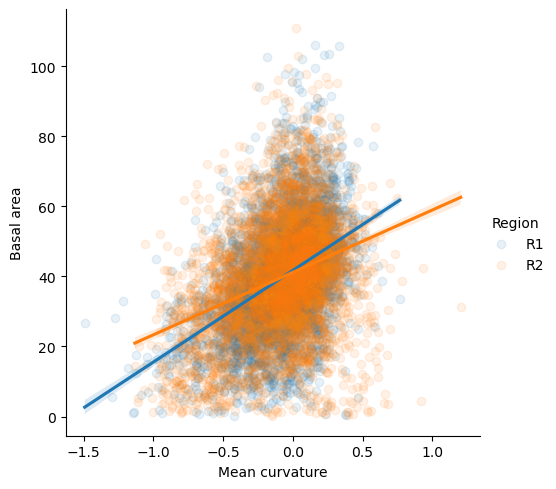

In [88]:
sb.lmplot(all_df.droplevel(1,axis=1),x='Mean curvature',y='Basal area',hue='Region',scatter_kws={'alpha':.1})

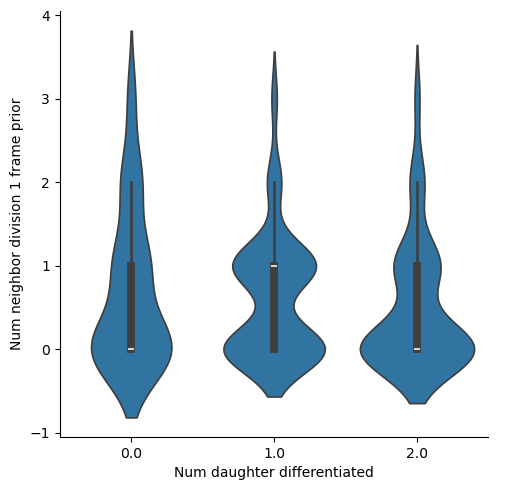

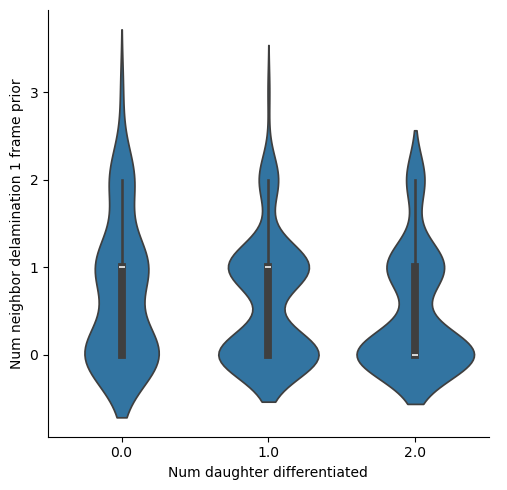

In [89]:
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Num neighbor division 1 frame prior',kind='violin')
sb.catplot(divisions.droplevel(1,axis=1),x='Num daughter differentiated',y='Num neighbor delamination 1 frame prior',kind='violin')

In [90]:
divisions.droplevel(1,axis=1).groupby('Num daughter differentiated')['Num neighbor division 1 frame prior'].mean()

Num daughter differentiated
0.0    0.696429
1.0    0.626087
2.0    0.500000
Name: Num neighbor division 1 frame prior, dtype: float64

In [91]:
divisions.droplevel(1,axis=1).groupby('Num daughter differentiated')['Num neighbor delamination 1 frame prior'].mean()

Num daughter differentiated
0.0    0.714286
1.0    0.617391
2.0    0.486486
Name: Num neighbor delamination 1 frame prior, dtype: float64

## Visualize 'average' cells

In [4]:
# Load images
from skimage import io

tracked_cyto_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_cyto.tif')) for name,dirname in dirnames.items()}
tracked_nuc_by_region = {name: io.imread(path.join(dirname,'Mastodon/tracked_nuc.tif')) for name,dirname in dirnames.items()}
adjdict_by_region = {name: [np.load(path.join(dirname,f'Mastodon/basal_connectivity_3d/adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item() for t in range(15)] for name,dirname in dirnames.items()}

%loadext autoreload
%autoreload 2

UsageError: Line magic function `%loadext` not found.


In [6]:
from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx
from imageUtils import trim_multimasks_to_shared_bounding_box, pad_image_to_size_centered, create_average_object_from_multiple_masks
from measurements import extract_nuc_and_cell_and_microenvironment_mask_from_idx

standard_size = (30,150,150)

def get_display_of_average_nuc_cyto_micro(ncm_list,largest_size=None):
    nuc = [m[0] for m in ncm_list]
    cyto = [m[1] for m in ncm_list]
    micro = [m[2] for m in ncm_list]
    nuc = create_average_object_from_multiple_masks(nuc,prealign=False)
    cyto = create_average_object_from_multiple_masks(cyto,prealign=False)
    micro = create_average_object_from_multiple_masks(micro,prealign=False)

    if largest_size is None:
        largest_size = np.array((nuc.shape,cyto.shape,micro.shape)).max(axis=0)
    nuc = pad_image_to_size_centered(nuc,largest_size)
    cyto = pad_image_to_size_centered(cyto,largest_size)
    micro = pad_image_to_size_centered(micro,largest_size)
    return nuc,cyto,micro
    

### Visualize using mask averaging

In [24]:

# Pull out all 'differentiating' birth frames
born_diff = births[births['Will differentiate','Meta']].xs('Measurement',level=1,axis=1)

born_diff_masks = []
for idx in born_diff.index:
    try: born_diff_masks.append(extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region))
    except:
        print(idx)

# Pull out all 'dividing' birth frames
born_divide = births[births['Will divide','Meta']].xs('Measurement',level=1,axis=1)
born_divide_masks = []
for idx in born_divide.index:
    try: born_divide_masks.append(extract_nuc_and_cell_and_microenvironment_mask_from_idx(idx,adjdict_by_region,
                                                                 tracked_nuc_by_region,tracked_cyto_by_region))
    except:
        print(idx)


(7, 'R2_525')


In [25]:
diff_nuc,diff_cyto,diff_micro = get_display_of_average_nuc_cyto_micro(born_diff_masks)
divide_nuc,divide_cyto,divide_micro = get_display_of_average_nuc_cyto_micro(born_divide_masks)

In [26]:
ipv.quickvolshow(diff_nuc, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [27]:
ipv.quickvolshow(divide_nuc, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [28]:
ipv.quickvolshow(diff_cyto, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

In [29]:
ipv.quickvolshow(divide_cyto, level=[.2,.5,1], opacity=0.05, level_width=0.05, data_min=0, data_max=2)

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.2, max=1.0, step…

### Average using spherical harmonics

In [107]:
feature_names = births.columns
cyto_coeffs = [f[0] for f in feature_names if f[0].startswith('cyto_shcoeffs_L')]
nuc_coeffs = [f[0] for f in feature_names if f[0].startswith('nuc_shcoeffs_L')]

mean_diff_coeffs = born_diff[cyto_coeffs].mean()
mean_divide_coeffs = born_divide[cyto_coeffs].mean()


In [108]:
from aicsshparam import shtools

def convert_sparse_coeff_matrix(coeffdict,lmax=5):
    mat = np.zeros((2, lmax + 1, lmax + 1), dtype=np.float32)
    for l in range(lmax):
        for m in range(lmax+1):
            for c,s in enumerate(['C','S']):
                key = f'cyto_shcoeffs_L{l}M{m}{s}'
                if key in coeffdict.index:
                    mat[c,l,m] = coeffdict[key]
    return mat

mat = convert_sparse_coeff_matrix(mean_divide_coeffs)
divide_cyto_mesh = shtools.get_reconstruction_from_coeffs(mat)[0]
mat = convert_sparse_coeff_matrix(mean_diff_coeffs)
diff_cyto_mesh = shtools.get_reconstruction_from_coeffs(mat)[0]


In [112]:
mean_diff_coeffs,mean_divide_coeffs

(Name
 cyto_shcoeffs_L0M0C    16.426823
 cyto_shcoeffs_L1M0C    -0.107348
 cyto_shcoeffs_L1M1C     0.042930
 cyto_shcoeffs_L2M0C     3.240140
 cyto_shcoeffs_L2M1C    -0.637104
 cyto_shcoeffs_L2M2C     1.391900
 cyto_shcoeffs_L3M0C     0.038460
 cyto_shcoeffs_L3M1C     0.046343
 cyto_shcoeffs_L3M2C     0.132445
 cyto_shcoeffs_L3M3C     0.009765
 cyto_shcoeffs_L4M0C     0.437587
 cyto_shcoeffs_L4M1C    -0.178161
 cyto_shcoeffs_L4M2C     0.425100
 cyto_shcoeffs_L4M3C    -0.087176
 cyto_shcoeffs_L4M4C     0.122747
 cyto_shcoeffs_L5M0C    -0.024243
 cyto_shcoeffs_L5M1C     0.022616
 cyto_shcoeffs_L5M2C     0.080280
 cyto_shcoeffs_L5M3C     0.000658
 cyto_shcoeffs_L5M4C     0.029015
 cyto_shcoeffs_L5M5C    -0.004995
 cyto_shcoeffs_L1M1S     0.058431
 cyto_shcoeffs_L2M1S     0.022634
 cyto_shcoeffs_L2M2S     0.000212
 cyto_shcoeffs_L3M1S     0.007936
 cyto_shcoeffs_L3M2S    -0.012129
 cyto_shcoeffs_L3M3S    -0.013272
 cyto_shcoeffs_L4M1S     0.033426
 cyto_shcoeffs_L4M2S    -0.008882
 cyto_sh

#### Meshes

In [109]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(divide_cyto_mesh))
pl.show()

Widget(value='<iframe src="http://localhost:54576/index.html?ui=P_0xcafc69850_13&reconnect=auto" class="pyvist…

In [110]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(diff_cyto_mesh))
pl.show()

Widget(value='<iframe src="http://localhost:54576/index.html?ui=P_0xd18c242b0_14&reconnect=auto" class="pyvist…

In [97]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(divide_cyto_mesh))
pl.show()

Name                Nuclear volume  Nuclear solidity    Z    Y    X  \
Will differentiate                                                    
False                          336               336  336  336  336   
True                           421               421  421  421  421   

Name                Nuclear height  Cell volume  Z-cyto  Y-cyto  X-cyto  ...  \
Will differentiate                                                       ...   
False                          336          336     336     336     336  ...   
True                           421          421     421     421     421  ...   

Name                Mean adjac cyto_shcoeffs_L2M1S at 1 frame prior  \
Will differentiate                                                    
False                                                           336   
True                                                            421   

Name                Relative Cell volume at 1 frame prior  \
Will differentiate                              